In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.145:36565 Dashboard: http://10.148.0.145:8787/status,Cluster Workers: 60 Cores: 240 Memory: 3000.00 GB


_________
# Read dataset


In [5]:
Nf = 4
data_dir = '/home1/scratch/xyu/mit_nc_t/'

filenames_Eta = sorted(glob(data_dir+'Eta_*.nc'))
filenames_Eta = filenames_Eta[:Nf]
ds_Eta = xr.open_mfdataset(filenames_Eta, concat_dim='time', compat='equals')

filenames_SSU = sorted(glob(data_dir+'SSU_*.nc'))
filenames_SSU = filenames_SSU[:Nf]
ds_SSU = xr.open_mfdataset(filenames_SSU, concat_dim='time', compat='equals')

filenames_SSV = sorted(glob(data_dir+'SSV_*.nc'))
filenames_SSV = filenames_SSV[:Nf]
ds_SSV = xr.open_mfdataset(filenames_SSV, concat_dim='time', compat='equals')

grid = xr.open_dataset('/home1/scratch/xyu/mit_grid.nc', decode_coords=True)


In [6]:
ds = xr.merge([ds_Eta, ds_SSU, ds_SSV, grid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 4)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
    dtime    (time) datetime64[ns] dask.array<shape=(4,), chunksize=(1,)>
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (face, j, i) float32 ...
    YC       (face, j, i) float32 ...
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 ...
    rA       (face, j, i) float32 ...
    dxG      (face, j_g, i) float32 ...
    dyG      (face, j, i_g) float32 ...
    Depth    (face, j, i) float32 ...
    rAz      (face, j_g, i_g) float32 ...
    dxC      (face, j, i_

In [7]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

---


# 1. Gradient of Bernoulli function (Eta)

# 1.1 Snapshot of Eta

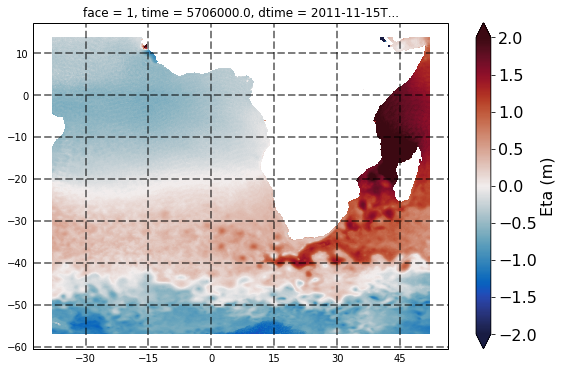

In [8]:
eta = ds['Eta'].isel(face=1, time=1)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

cax = eta.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=-2, vmax=2, add_colorbar = False, cmap = cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
ax.tick_params(labelsize=16)

cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Eta (m)', fontsize=16)


# 1.2 face connections

In [9]:
face_connections = {'face': {0: {'X': ((12, 'Y', False), (3, 'X', False)),
                                 'Y': (None, (1, 'Y', False))},
                             1: {'X': ((11, 'Y', False), (4, 'X', False)),
                                 'Y': ((0, 'Y', False), (2, 'Y', False))},
                             2: {'X': ((10, 'Y', False), (5, 'X', False)),
                                 'Y': ((1, 'Y', False), (6, 'X', False))},
                             3: {'X': ((0, 'X', False), (9, 'Y', False)),
                                 'Y': (None, (4, 'Y', False))},
                             4: {'X': ((1, 'X', False), (8, 'Y', False)),
                                 'Y': ((3, 'Y', False), (5, 'Y', False))},
                             5: {'X': ((2, 'X', False), (7, 'Y', False)),
                                 'Y': ((4, 'Y', False), (6, 'Y', False))},
                             6: {'X': ((2, 'Y', False), (7, 'X', False)),
                                 'Y': ((5, 'Y', False), (10, 'X', False))},
                             7: {'X': ((6, 'X', False), (8, 'X', False)),
                                 'Y': ((5, 'X', False), (10, 'Y', False))},
                             8: {'X': ((7, 'X', False), (9, 'X', False)),
                                 'Y': ((4, 'X', False), (11, 'Y', False))},
                             9: {'X': ((8, 'X', False), None),
                                 'Y': ((3, 'X', False), (12, 'Y', False))},
                             10: {'X': ((6, 'Y', False), (11, 'X', False)),
                                  'Y': ((7, 'Y', False), (2, 'X', False))},
                             11: {'X': ((10, 'X', False), (12, 'X', False)),
                                  'Y': ((8, 'Y', False), (1, 'X', False))},
                             12: {'X': ((11, 'X', False), None),
                                  'Y': ((9, 'Y', False), (0, 'X', False))}}}

In [10]:
x_grid = xgcm.Grid(ds, face_connections=face_connections)
print(x_grid)

<xgcm.Grid>
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center


# 1.3 Gradient of 'pressure' (i.e. dphi/dy)

In [11]:
g = 9.81

In [12]:
dphi_dy = (x_grid.diff(g*ds['Eta'],'Y', boundary='extend'))/ds.dyC

print(dphi_dy)

<xarray.DataArray (time: 4, face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(4, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 1, 4320)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    dxG      (face, j_g, i) float32 ...
    dyC      (face, j_g, i) float32 ...
    rAs      (face, j_g, i) float32 ...


# 1.4 one snapshot for dphi/dx

In [13]:
dphi_dy_time1 = dphi_dy.isel(time=1)
print(dphi_dy_time1)

<xarray.DataArray (face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 1, 4320)>
Coordinates:
    time     float64 5.706e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    dxG      (face, j_g, i) float32 ...
    dyC      (face, j_g, i) float32 ...
    rAs      (face, j_g, i) float32 ...


In [14]:
dphi_dy_time1_face1 = dphi_dy_time1.isel(face=1)
print(dphi_dy_time1_face1)

<xarray.DataArray (j_g: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(1, 4320)>
Coordinates:
    time     float64 5.706e+06
    face     int64 1
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    dxG      (j_g, i) float32 ...
    dyC      (j_g, i) float32 ...
    rAs      (j_g, i) float32 ...


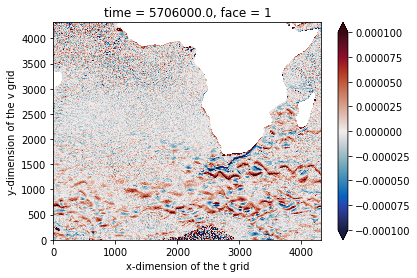

In [16]:
dphi_dy_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

_______

# 2 Linear Coriolis terms

## 2.1 G_u(fv) ---> SSV

In [17]:
#import xgcm
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center

In [18]:
SSU_dyG = ds.dyG * ds['SSU']
print(SSU_dyG)

<xarray.DataArray (face: 13, j: 4320, i_g: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 4320, 4320, 1)>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dyG      (face, j, i_g) float32 478.96072 478.9889 479.01703 479.0451 ...
    dxC      (face, j, i_g) float32 324.6357 324.63788 324.64 324.64215 ...
    rAw      (face, j, i_g) float32 155487.83 155497.98 155508.08 155518.31 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
    dtime    (time) datetime64[ns] dask.array<shape=(4,), chunksize=(1,)>


In [19]:
dyGSSU_i = grid.interp(SSU_dyG,'X')
print(dyGSSU_i)

<xarray.DataArray 'mul-24f943fc27cb5086fb28b2049a937b17' (face: 13, j: 4320, i: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 4320, 4319, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06


In [20]:
dyGSSU_ij = grid.interp(dyGSSU_i,'Y')
print(dyGSSU_ij)

<xarray.DataArray 'mul-aac7fe4f0cae5aecf32baf6143e1859e' (face: 13, j_g: 4320, i: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 1, 4319, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06


In [21]:
dyGSSU_ij_time1 = dyGSSU_ij.isel(time=1)
print(dyGSSU_ij_time1)

<xarray.DataArray 'mul-aac7fe4f0cae5aecf32baf6143e1859e' (face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 1, 4319)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    time     float64 5.706e+06


In [22]:
lat = ds['YG']
print(lat)

<xarray.DataArray 'YG' (face: 13, j_g: 4320, i_g: 4320)>
[242611200 values with dtype=float32]
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 ...
    rAz      (face, j_g, i_g) float32 ...
Attributes:
    standard_name:  latitude_at_f_location
    long_name:      latitude
    units:          degrees_north


In [23]:
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
print(f)

<xarray.DataArray 'YG' (face: 13, j_g: 4320, i_g: 4320)>
array([[[-1.459260e-04, -1.459262e-04, ..., -1.439605e-04, -1.439600e-04],
        [-1.459260e-04, -1.459262e-04, ..., -1.439605e-04, -1.439600e-04],
        ...,
        [-1.224857e-04, -1.224857e-04, ..., -1.224857e-04, -1.224857e-04],
        [-1.224704e-04, -1.224704e-04, ..., -1.224704e-04, -1.224704e-04]],

       [[-1.224550e-04, -1.224550e-04, ..., -1.224550e-04, -1.224550e-04],
        [-1.224396e-04, -1.224396e-04, ..., -1.224396e-04, -1.224396e-04],
        ...,
        [ 3.457887e-05,  3.457887e-05, ...,  3.457887e-05,  3.457887e-05],
        [ 3.462502e-05,  3.462502e-05, ...,  3.462502e-05,  3.462502e-05]],

       ...,

       [[ 3.467117e-05,  3.462502e-05, ..., -1.224243e-04, -1.224396e-04],
        [ 3.467117e-05,  3.462502e-05, ..., -1.224243e-04, -1.224396e-04],
        ...,
        [ 3.467117e-05,  3.462502e-05, ..., -1.224243e-04, -1.224396e-04],
        [ 3.467117e-05,  3.462502e-05, ..., -1.224243e-04, -1.

In [24]:
f_i = grid.interp(f,'X')
print(f_i)

<xarray.DataArray (face: 13, j_g: 4320, i: 4320)>
array([[[-1.459261e-04, -1.459264e-04, ..., -1.439603e-04, -1.449430e-04],
        [-1.459261e-04, -1.459264e-04, ..., -1.439603e-04, -1.449430e-04],
        ...,
        [-1.224857e-04, -1.224857e-04, ..., -1.224857e-04, -1.224857e-04],
        [-1.224704e-04, -1.224704e-04, ..., -1.224704e-04, -1.224704e-04]],

       [[-1.224550e-04, -1.224550e-04, ..., -1.224550e-04, -1.224550e-04],
        [-1.224396e-04, -1.224396e-04, ..., -1.224396e-04, -1.224396e-04],
        ...,
        [ 3.457887e-05,  3.457887e-05, ...,  3.457887e-05,  3.457887e-05],
        [ 3.462502e-05,  3.462502e-05, ...,  3.462502e-05,  3.462502e-05]],

       ...,

       [[ 3.464810e-05,  3.460194e-05, ..., -1.224320e-04, -4.388423e-05],
        [ 3.464810e-05,  3.460194e-05, ..., -1.224320e-04, -4.388423e-05],
        ...,
        [ 3.464810e-05,  3.460194e-05, ..., -1.224320e-04, -4.388423e-05],
        [ 3.464810e-05,  3.460194e-05, ..., -1.224320e-04, -4.388423e

In [25]:
Coriolis_v = -f_i * dyGSSU_ij /ds.dyC
print(Coriolis_v)   

<xarray.DataArray (face: 13, j_g: 4320, i: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 1, 4319, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
    dxG      (face, j_g, i) float32 ...
    dyC      (face, j_g, i) float32 ...
    rAs      (face, j_g, i) float32 ...


In [26]:
Coriolis_v_time1_face1 = Coriolis_v.isel(face=1,time=1)
print(Coriolis_v_time1_face1)

<xarray.DataArray (j_g: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(1, 4319)>
Coordinates:
    face     int64 1
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    time     float64 5.706e+06
    dxG      (j_g, i) float32 ...
    dyC      (j_g, i) float32 ...
    rAs      (j_g, i) float32 ...


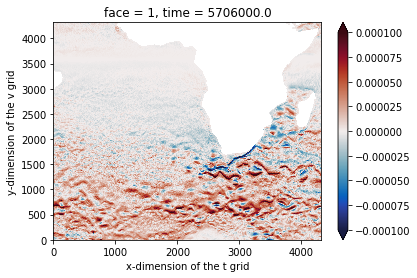

In [27]:
Coriolis_v_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 3 Time derivative of SSV

In [28]:
SSV_time2 = ds['SSV'].isel(time=2)
print(SSV_time2)

<xarray.DataArray 'SSV' (face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 4320, 4320)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    time     float64 5.71e+06
    dtime    datetime64[ns] dask.array<shape=(), chunksize=()>
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dxG      (face, j_g, i) float32 ...
    dyC      (face, j_g, i) float32 ...
    rAs      (face, j_g, i) float32 ...


In [29]:
SSV_time0 = ds['SSV'].isel(time=0)
print(SSV_time0)

<xarray.DataArray 'SSV' (face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 4320, 4320)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    time     float64 5.702e+06
    dtime    datetime64[ns] dask.array<shape=(), chunksize=()>
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dxG      (face, j_g, i) float32 ...
    dyC      (face, j_g, i) float32 ...
    rAs      (face, j_g, i) float32 ...


In [30]:
d_SSV_dt_time1 = (SSV_time2 - SSV_time0)/2/3600
print(d_SSV_dt_time1)

<xarray.DataArray 'SSV' (face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 4320, 4320)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dxG      (face, j_g, i) float32 324.63684 324.639 324.64114 324.64328 ...
    dyC      (face, j_g, i) float32 239.48717 239.50125 239.51529 239.52933 ...
    rAs      (face, j_g, i) float32 77743.875 77748.9 77753.945 77759.03 ...


In [31]:
d_SSV_dt_time1_face1 = d_SSV_dt_time1.isel(face=1)
print(d_SSV_dt_time1_face1)

<xarray.DataArray 'SSV' (j_g: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(4320, 4320)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dxG      (j_g, i) float32 1261.269 1261.269 1261.269 1261.269 1261.269 ...
    dyC      (j_g, i) float32 1230.864 1230.864 1230.864 1230.864 1230.864 ...
    rAs      (j_g, i) float32 1552450.8 1552450.9 1552450.8 1552450.8 ...


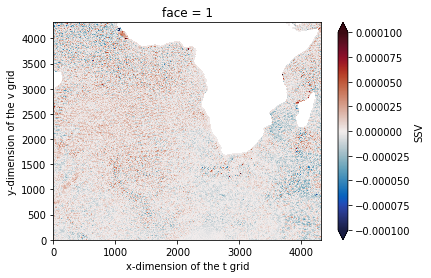

In [32]:
d_SSV_dt_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 4. Relative vorticity

In [33]:
SSV_dyC = ds.dyC * ds['SSV']
d_SSV_dyC_di = grid.diff(SSV_dyC,'X')
print(d_SSV_dyC_di)

<xarray.DataArray 'sub-7957a6e3d5bd2abfdb122f669b20923c' (face: 13, j_g: 4320, i_g: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 4320, 1, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06


In [34]:
SSU_dxC = ds.dxC * ds['SSU']
d_SSU_dxC_dj = grid.diff(SSU_dxC,'Y')
print(d_SSU_dxC_dj)

<xarray.DataArray 'sub-8f940b28c6c27391db526772f2bacc03' (face: 13, j_g: 4320, i_g: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 1, 4320, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06


In [35]:
zeta_3 = (d_SSV_dyC_di - d_SSU_dxC_dj)/ds.rAz
print(zeta_3)

<xarray.DataArray (face: 13, j_g: 4320, i_g: 4320, time: 4)>
dask.array<shape=(13, 4320, 4320, 4), dtype=float32, chunksize=(13, 1, 1, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 -88.17569 -88.17861 -88.181526 ...
    rAz      (face, j_g, i_g) float32 ...


In [36]:
zeta_3_time1 = zeta_3.isel(time=1)
print(zeta_3_time1)

<xarray.DataArray (face: 13, j_g: 4320, i_g: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 1, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    time     float64 5.706e+06
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 -88.17569 -88.17861 -88.181526 ...
    rAz      (face, j_g, i_g) float32 ...


In [37]:
zeta_3_time1_i = grid.interp(zeta_3_time1,'X')
print(zeta_3_time1_i)

<xarray.DataArray 'mul-d0d35499332f36140db607e7a9c76aa1' (face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 1, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


In [38]:
Coriolis_zeta3_v = -zeta_3_time1_i * dyGSSU_ij_time1 /ds.dyC
print(Coriolis_zeta3_v)

<xarray.DataArray (face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=float32, chunksize=(13, 1, 1)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    time     float64 5.706e+06
    dxG      (face, j_g, i) float32 ...
    dyC      (face, j_g, i) float32 ...
    rAs      (face, j_g, i) float32 ...


In [39]:
Coriolis_zeta3_v_time1_face1 = Coriolis_zeta3_v.isel(face=1)

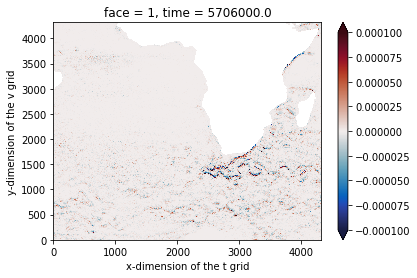

In [40]:
(Coriolis_zeta3_v_time1_face1).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 5. KE

In [41]:
SSU_2 = ds['SSU'] * ds['SSU']
SSU_2_i = grid.interp(SSU_2,'X')
print(SSU_2_i)

<xarray.DataArray 'mul-30804fab6b51ecda8b910de766465721' (time: 4, face: 13, j: 4320, i: 4320)>
dask.array<shape=(4, 13, 4320, 4320), dtype=float32, chunksize=(1, 13, 4320, 4319)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


In [42]:
SSV_2 = ds['SSV'] * ds['SSV']
SSV_2_j = grid.interp(SSV_2,'Y')
print(SSV_2_j)

<xarray.DataArray 'mul-4e0f0ccbc7fa8475d9c36224bbf86d12' (time: 4, face: 13, j: 4320, i: 4320)>
dask.array<shape=(4, 13, 4320, 4320), dtype=float32, chunksize=(1, 13, 4319, 4320)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


In [43]:
KE = (SSU_2_i + SSV_2_j)/2
print(KE)

<xarray.DataArray (time: 4, face: 13, j: 4320, i: 4320)>
dask.array<shape=(4, 13, 4320, 4320), dtype=float32, chunksize=(1, 13, 4319, 4319)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


In [44]:
dKE_dy = (x_grid.diff(KE,'Y', boundary='extend'))/ds.dyC
print(dKE_dy)

<xarray.DataArray (time: 4, face: 13, j_g: 4320, i: 4320)>
dask.array<shape=(4, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 1, 1)>
Coordinates:
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    dxG      (face, j_g, i) float32 ...
    dyC      (face, j_g, i) float32 ...
    rAs      (face, j_g, i) float32 ...


In [45]:
dKE_dy_time1_face1 = dKE_dy.isel(time=1,face=1)
print(dKE_dy_time1_face1)

<xarray.DataArray (j_g: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(1, 1)>
Coordinates:
    time     float64 5.706e+06
    face     int64 1
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    dxG      (j_g, i) float32 ...
    dyC      (j_g, i) float32 ...
    rAs      (j_g, i) float32 ...


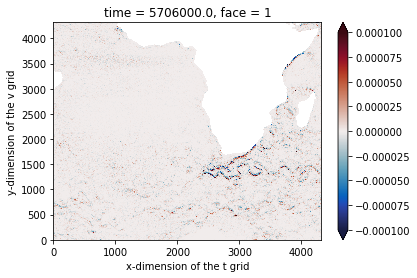

In [46]:
dKE_dy_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

# 6. Residuals

In [47]:
residuals_v_time1_face1 = d_SSV_dt_time1_face1 - Coriolis_v_time1_face1 - Coriolis_zeta3_v_time1_face1 + dphi_dy_time1_face1 + dKE_dy_time1_face1
print(residuals_v_time1_face1)

<xarray.DataArray (j_g: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float32, chunksize=(1, 1)>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    dxG      (j_g, i) float32 1261.269 1261.269 1261.269 1261.269 1261.269 ...
    dyC      (j_g, i) float32 1230.864 1230.864 1230.864 1230.864 1230.864 ...
    rAs      (j_g, i) float32 1552450.8 1552450.9 1552450.8 1552450.8 ...
    time     float64 5.706e+06


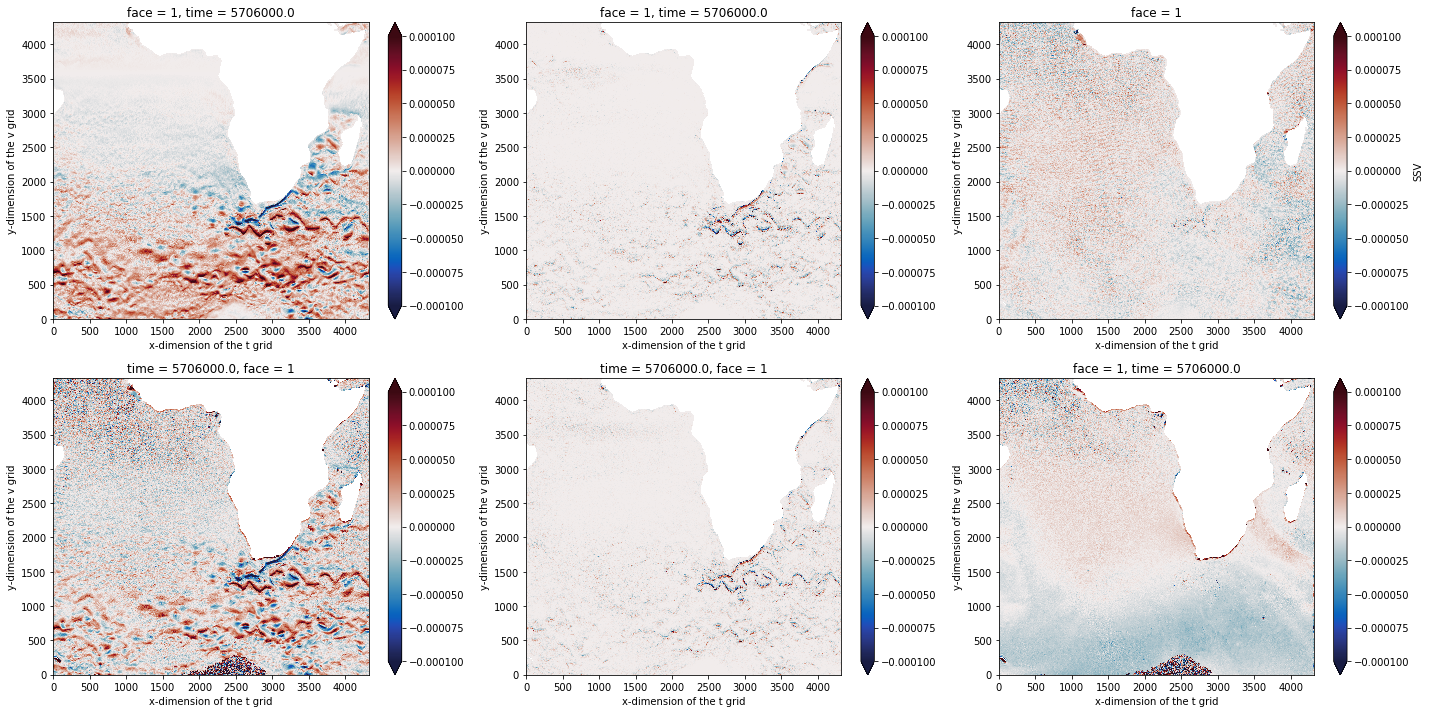

In [48]:
fig = plt.figure(figsize = (24,12))

plt.subplot(231)
Coriolis_v_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(234)
dphi_dy_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

plt.subplot(232)
Coriolis_zeta3_v_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(235)
dKE_dy_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

plt.subplot(233)
d_SSV_dt_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(236)
residuals_v_time1_face1.plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Gv_face1_time1.png')



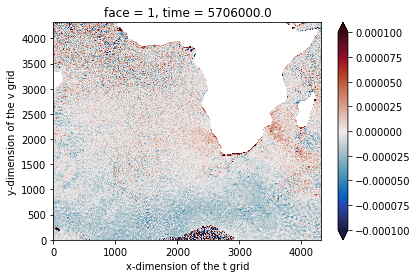

In [49]:
(- Coriolis_v_time1_face1 + dphi_dy_time1_face1).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)     # Coriolis term + pressure gradient

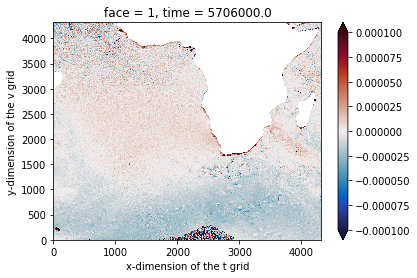

In [50]:
(- Coriolis_v_time1_face1 + dphi_dy_time1_face1 + d_SSV_dt_time1_face1).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)   # Coriolis term(linear) + pressure gradient + time derivative

In [68]:
(Coriolis_v_time1_face1**2).isel(i=slice(500,2000), j_g=slice(500,2000)).mean(['i','j_g']).compute()

<xarray.DataArray ()>
array(4.087198e-10, dtype=float32)
Coordinates:
    face     int64 1
    time     float64 5.706e+06

In [69]:
(dphi_dy_time1_face1**2).isel(i=slice(500,2000), j_g=slice(500,2000)).mean(['i','j_g']).compute()

<xarray.DataArray ()>
array(3.06829e-10, dtype=float32)
Coordinates:
    time     float64 5.706e+06
    face     int64 1

In [70]:
(d_SSV_dt_time1_face1**2).isel(i=slice(500,2000), j_g=slice(500,2000)).mean(['i','j_g']).compute()

<xarray.DataArray 'SSV' ()>
array(9.206518e-11, dtype=float32)
Coordinates:
    face     int64 1

In [71]:
(residuals_v_time1_face1**2).isel(i=slice(500,2000), j_g=slice(500,2000)).mean(['i','j_g']).compute()

<xarray.DataArray ()>
array(6.449607e-11, dtype=float32)
Coordinates:
    face     int64 1
    time     float64 5.706e+06

In [52]:
cluster.scheduler.close()

<Future finished result=None>